In [1]:
import torch
import numpy as np
import pandas as pd
from scipy.special import hyp2f1
import datetime
from pathlib import Path

from models import model_selection, get_best_crit, model_evaluation
#from extreme.estimators import evt_estimators
from extreme import visualization as xviz
from extreme.data_management import DataSampler, load_quantiles, load_real_data
from extreme.estimators import real_estimators, confidence_interval, get_gammaRB, get_real_cte_half, ExtremeQuantileEstimator

from rpy2 import robjects as ro
import rpy2.robjects.numpy2ri

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

%load_ext autoreload
%autoreload 2

# Data Description

## Load Data

In [2]:
df_real = pd.read_csv("data/real/norwegian90.csv")
df_real

,fire
0,500
1,500
2,500
3,504
4,504
...,...
623,20831
624,25509
625,26331
626,41276


## Hill Plot

\hat\gamma(k^\star=279)=0.6170444862036427


0.6170444862036427

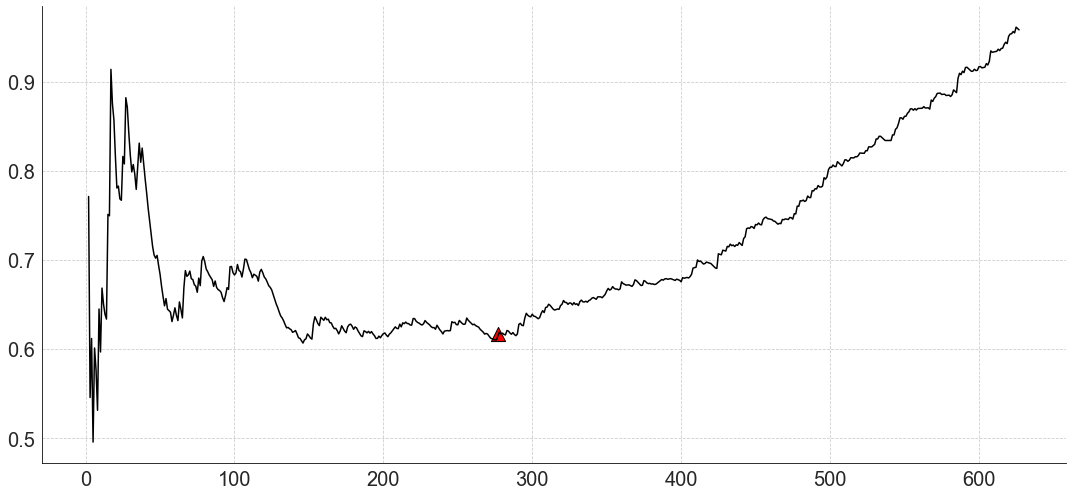

In [3]:
xviz.real_hill_plot(saved=False)

## LogLog plot

$\hat\gamma(k^\star)=$ 0.6170444862036427


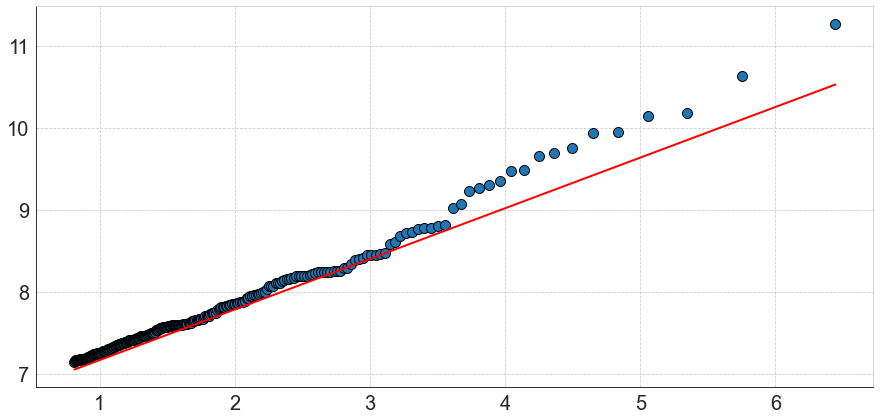

In [4]:
xviz.real_loglog_plot(percentile=1-279/df_real.shape[0], gamma_hill=0.6170444862036427, saved=True)

## Train-Test Split

\begin{align}
&\mathcal X_{\text train} = \{X_{n-i+1, n}, i=\lfloor n(1-\xi)\rfloor,\dots,n \},\\
& \mathcal X_{\text test} = \{X_{n-i+1, n}, i=1,\dots,\lceil n(1-\xi)\rceil \}
\end{align}

In [5]:
XI = 0.9
n = df_real.shape[0]
Xtrain = df_real[:int(np.floor(XI*n))]
ntrain = Xtrain.shape[0]
Xtest = df_real[-int(np.ceil((1-XI)*n)):]

In [6]:
Xtrain

,fire
0,500
1,500
2,500
3,504
4,504
...,...
560,2985
561,3074
562,3210
563,3211


In [7]:
Xtest

,fire
565,3318
566,3333
567,3340
568,3404
569,3465
...,...
623,20831
624,25509
625,26331
626,41276


# BCTM Estimation

## a=0.5

167.22097683392485


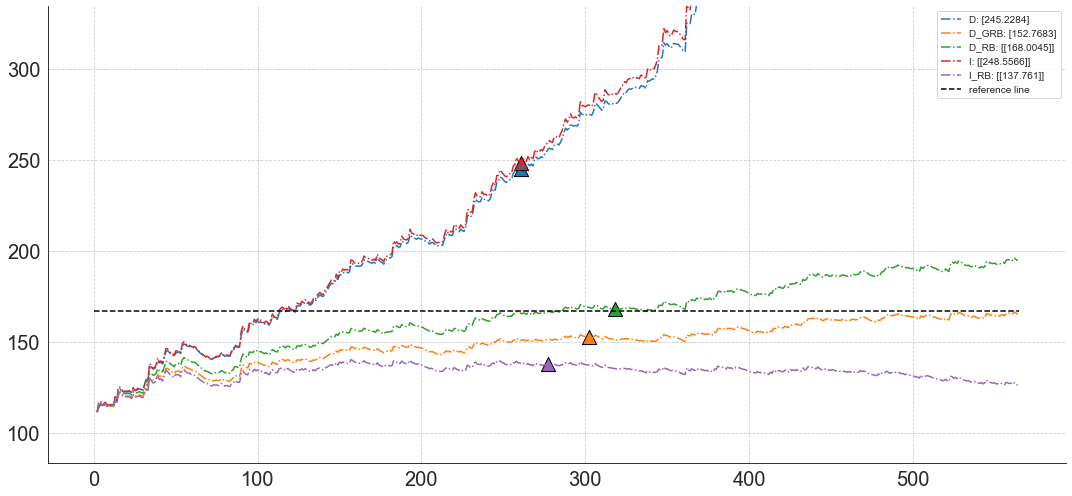

In [8]:
xviz.xes_real_bias_plot(a=0.5, xi=0.9, saved=False)

## a=1

8731.0


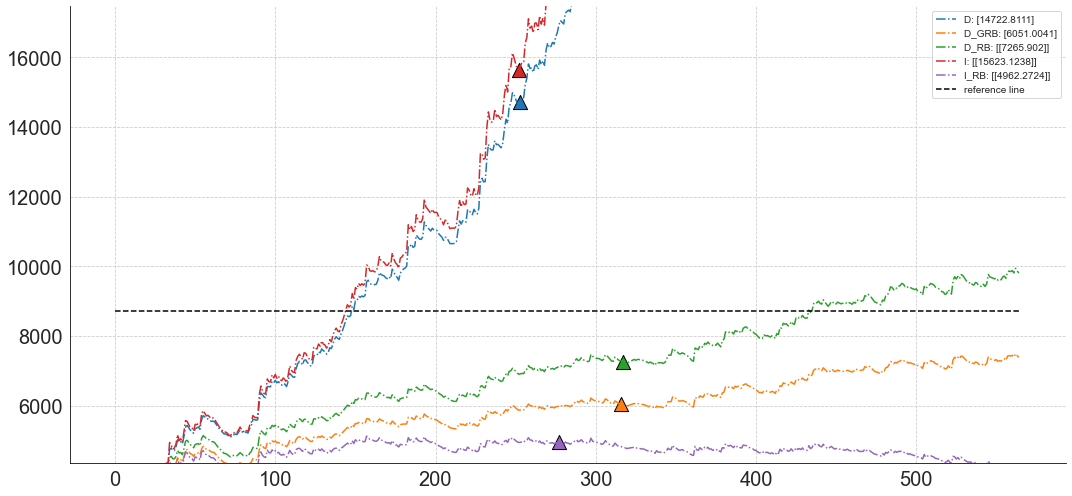

In [9]:
xviz.xes_real_bias_plot(a=1, xi=0.9, saved=False)

# Rho estimation

In [10]:
rpy2.robjects.numpy2ri.activate()
r = ro.r
r['source']('extreme/revt.R')
get_rho_beta = r.get_rho_beta

R[write to console]: Le chargement a nécessité le package : evd



In [11]:
# train
rho, beta = get_rho_beta(np.sort(Xtrain)) 
rho, beta

(array([-0.49016798]), array([0.95079415]))

In [12]:
# test
rho, beta = get_rho_beta(np.sort(Xtest)) 
rho, beta

(array([-2.05879545]), array([-1.51441022]))

In [13]:
# full
rho, beta = get_rho_beta(np.sort(df_real)) 
rho, beta

(array([-1.84736233]), array([0.77837252]))

# CTE estimation through BCTM
\begin{align}
\label{eq:bctm:1:2}
\widehat{\rm CTE}(p_n;1/2) = \frac{1}{1-\widehat\gamma(k_n^\star)}\left( \left(1-\frac{\widehat\gamma(k_n^\star)}{2}\right)\left( 1+\frac{1}{2} \widehat{\mathcal M}_{1/2}(p_n)\right)\right)^2.
\end{align}

In [10]:
## X_train and hill
cte_half = get_real_cte_half(xi=0.9, gamma_estimator="hill")
cte_half

Gamma estimation: 0.4405513802205444


{'D': array([16605.75095024]),
 'D_GRB': array([6507.67388326]),
 'D_RB': array([[7852.04576806]]),
 'I': array([[17055.85536721]]),
 'I_RB': array([[5306.81706695]]),
 'emp': 8732.0}

# Confidence interval

## a=1

In [11]:
res_real_1 = real_estimators(a=1, xi=0.9, return_full=True)
for estimator in res_real_1:
    bctm = res_real_1[estimator]['median']['q_bestK'][0]
    cte = bctm + 1
    k_star = res_real_1[estimator]['median']['bestK'][0]
    gammaRB = get_gammaRB(Xtrain.to_numpy().ravel(), k_star)
    ci_left, ci_right = confidence_interval(cte, gammaRB, k_star, a=1)
    
    print('Estimator: ', estimator)
    print("CTE:", cte)
    print('CI:', (ci_left[0], ci_right[0]))
    print("\n")
    

Estimator:  D
CTE: 14723.811111257004
CI: (12601.674835237214, 17705.34260796198)


Estimator:  D_GRB
CTE: 6052.00413933189
CI: (5201.033806362013, 7235.835857580666)


Estimator:  D_RB
CTE: [7266.90200351]
CI: (6248.101858004701, 8682.60228730692)


Estimator:  I
CTE: [15624.123829]
CI: (13372.312920044667, 18787.799405989503)


Estimator:  I_RB
CTE: [4963.27240371]
CI: (4250.680340057145, 5962.823938000565)




## a=0.5

In [12]:
cte_half

{'D': array([16605.75095024]),
 'D_GRB': array([6507.67388326]),
 'D_RB': array([[7852.04576806]]),
 'I': array([[17055.85536721]]),
 'I_RB': array([[5306.81706695]]),
 'emp': 8732.0}

In [14]:
res_real_half = real_estimators(a=0.5, xi=0.9, return_full=True)
cte_half = get_real_cte_half(xi=0.9, gamma_estimator="hill")
for estimator in list(cte_half.keys())[:-1]:
    cte = cte_half[estimator]
    k_half = res_real_half[estimator]['median']['bestK'][0]
    gammaRB = get_gammaRB(Xtrain.to_numpy().ravel(), k_half)
    ci_left, ci_right = confidence_interval(cte, gammaRB, k_half, a=1)
    
    print('Estimator: ', estimator)
    print("CTE:", cte)
    print('CI:', (ci_left[0], ci_right[0]))
    print("\n")

Gamma estimation: 0.4405513802205444
Estimator:  D
CTE: [16605.75095024]
CI: (14206.08339440843, 19980.80625512324)


Estimator:  D_GRB
CTE: [6507.67388326]
CI: (5577.219034061351, 7810.671827135887)


Estimator:  D_RB
CTE: [[7852.04576806]]
CI: (array([6752.23298443]), array([9379.77231578]))


Estimator:  I
CTE: [[17055.85536721]]
CI: (array([14591.14793878]), array([20522.38716288]))


Estimator:  I_RB
CTE: [[5306.81706695]]
CI: (array([4544.91119039]), array([6375.54099295]))




# Risk Premiums

In [15]:
extreme_risk_level = 1/(2*ntrain)
quantile_estimator = ExtremeQuantileEstimator(X=Xtrain.to_numpy().ravel(), 
                                              alpha=extreme_risk_level)


## EMP

In [16]:
# Risk Premium
extreme_risk_level * (cte_half['emp'] - Xtest.to_numpy().ravel()[0])

4.791150442477876

## a=1

In [17]:
res_real_1 = real_estimators(a=1, xi=0.9, return_full=True)

### With bias

#### Direct

In [18]:
cte_D_1 = res_real_1['D']['median']['q_bestK'][0] + 1
k_D_1 = res_real_1['D']['median']['bestK'][0]
weissman_D_1 = quantile_estimator.weissman(k_D_1)
cte_D_1, k_D_1, weissman_D_1

(14723.811111257004, 253, 12651.674775528223)

In [21]:
# Risk Premium
extreme_risk_level * (cte_D_1 - weissman_D_1)

1.8337489696714875

#### Indirect

In [22]:
cte_I_1 = res_real_1['I']['median']['q_bestK'][0] + 1
k_I_1 = res_real_1['I']['median']['bestK'][0]
weissman_I_1 = quantile_estimator.weissman(k_I_1)
cte_I_1, k_I_1, weissman_I_1

(array([15624.123829]), 252, 12557.45308791421)

In [23]:
# Risk Premium
extreme_risk_level * (cte_I_1[0] - weissman_I_1)

2.71386791246538

### Bias Reduced

#### D,GRB

In [24]:
cte_D_GRB_1 = res_real_1['D_GRB']['median']['q_bestK'][0] + 1
k_D_GRB_1 = res_real_1['D_GRB']['median']['bestK'][0]
weissman_D_GRB_1 = quantile_estimator.r_weissman(k_D_GRB_1)
cte_D_GRB_1, k_D_GRB_1, weissman_D_GRB_1

(6052.00413933189, 316, 3454.9768998428212)

In [25]:
# Risk Premium
extreme_risk_level * (cte_D_GRB_1 - weissman_D_GRB_1)

2.2982541942381136

#### D,RB

In [26]:
cte_D_RB_1 = res_real_1['D_RB']['median']['q_bestK'][0] + 1
k_D_RB_1 = res_real_1['D_RB']['median']['bestK'][0]
weissman_D_RB_1 = quantile_estimator.r_weissman(k_D_RB_1)
cte_D_RB_1, k_D_RB_1, weissman_D_RB_1

(array([7266.90200351]), 317, 3450.1038494343184)

In [27]:
# Risk Premium
extreme_risk_level * (cte_D_RB_1 - weissman_D_RB_1)

array([3.37769748])

#### I,RB

In [28]:
cte_I_RB_1 = res_real_1['I_RB']['median']['q_bestK'][0] + 1
k_I_RB_1 = res_real_1['I_RB']['median']['bestK'][0]
weissman_I_RB_1 = quantile_estimator.r_weissman(k_I_RB_1)
cte_I_RB_1, k_I_RB_1, weissman_I_RB_1

(array([4963.27240371]), 277, 3850.4959991437354)

In [29]:
# Risk Premium
extreme_risk_level * (cte_I_RB_1 - weissman_I_RB_1)

array([0.98475788])

## a=1/2

In [30]:
res_real_half = real_estimators(a=0.5, xi=0.9, return_full=True)
cte_half = get_real_cte_half(xi=0.9, gamma_estimator="hill")

Gamma estimation: 0.4405513802205444


### With bias

#### Direct

In [31]:
cte_D_half = cte_half['D']
k_D_half = res_real_half['D']['median']['bestK'][0]
weissman_D_half = quantile_estimator.weissman(k_D_half)
cte_D_half, k_D_half, weissman_D_half

(array([16605.75095024]), 261, 13289.568953224461)

In [32]:
# Risk Premium
extreme_risk_level * (cte_D_half - weissman_D_half)

array([2.93467433])

#### Indirect

In [33]:
cte_I_half = cte_half['I']
k_I_half = res_real_half['I']['median']['bestK'][0]
weissman_I_half = quantile_estimator.weissman(k_I_half)
cte_I_half, k_I_half, weissman_I_half

(array([[17055.85536721]]), 261, 13289.568953224461)

In [34]:
# Risk Premium
extreme_risk_level * (cte_I_half - weissman_I_half)

array([[3.33299683]])

### Bias Reduced

#### D,GRB

In [35]:
cte_D_GRB_half = cte_half['D_GRB']
k_D_GRB_half = res_real_half['D_GRB']['median']['bestK'][0]
weissman_D_GRB_half = quantile_estimator.r_weissman(k_D_GRB_half)
cte_D_GRB_half, k_D_GRB_half, weissman_D_GRB_half

(array([6507.67388326]), 302, 3605.40271005986)

In [36]:
# Risk Premium
extreme_risk_level * (cte_D_GRB_half - weissman_D_GRB_half)

array([2.56838157])

#### D,RB

In [37]:
cte_D_RB_half = cte_half['D_RB']
k_D_RB_half = res_real_half['D_RB']['median']['bestK'][0]
weissman_D_RB_half = quantile_estimator.r_weissman(k_D_RB_half)
cte_D_RB_half, k_D_RB_half, weissman_D_RB_half

(array([[7852.04576806]]), 318, 3448.7145577998886)

In [38]:
# Risk Premium
extreme_risk_level * (cte_D_RB_half - weissman_D_RB_half)

array([[3.89675328]])

#### I,RB

In [39]:
cte_I_RB_half = cte_half['I_RB']
k_I_RB_half = res_real_half['I_RB']['median']['bestK'][0]
weissman_I_RB_half = quantile_estimator.r_weissman(k_I_RB_half)
cte_I_RB_half, k_I_RB_half, weissman_I_RB_half

(array([[5306.81706695]]), 277, 3850.4959991437354)

In [40]:
# Risk Premium
extreme_risk_level * (cte_I_RB_half - weissman_I_RB_half)

array([[1.28877971]])